На этом занятии мы попробуем задачу регрессии. Данные в этой же папке, будем тренироваться на датасете фильмов с IMDB

Перед обучением обучением модели, нужно подготовить данные:

- найти\собрать данные
- почистить и предобработать
- преобразовать в матрицы 


In [79]:
# импорты необходимых библиотек
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

# import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, get_scorer

import numpy as np

In [3]:
data = pd.read_csv('IMDB-Movie-Data.csv')
print(data.shape)

data.head(3)

(1000, 12)


,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0


## Что делать с NaN?
Есть 3 варианта

In [4]:
# 1. Убрать строки с NaN
print(data.isna().any())
data.shape

Rank                  False
Title                 False
Genre                 False
Description           False
Director              False
Actors                False
Year                  False
Runtime (Minutes)     False
Rating                False
Votes                 False
Revenue (Millions)     True
Metascore              True
dtype: bool


(1000, 12)

In [26]:
print(data.shape)
tmp = data.dropna()
tmp.shape

(1000, 13)


(838, 13)

In [40]:
# 2. Превратить NaN в 0
print(data.shape)
tmp = data.fillna(0)
print(tmp.shape)

(1000, 13)
(1000, 13)


In [41]:
# 3. Превратить NaN в средние значения по колонке

# вычисляем средние для колонок с пустыми значениями
meta_mean = data.Metascore.mean()
rev_mean = data['Revenue (Millions)'].mean()

#заменяем пустоты на средние значения
data.Metascore.fillna(meta_mean, inplace=True)
data['Revenue (Millions)'].fillna(rev_mean, inplace=True)

# проверяем присутствие NaN
data.isna().any()

Rank                  False
Title                 False
Genre                 False
Description           False
Director              False
Actors                False
Year                  False
Runtime (Minutes)     False
Rating                False
Votes                 False
Revenue (Millions)    False
Metascore             False
text                  False
dtype: bool

## Подготовка данных

Попробуем предсказывать рейтинг фильма по данным его описания, года, длины в минутах и кассовых сборов

Колонка "Rating" станет **целевой переменной, или таргетом** (y)<br>
Остальных данные будут **обучающей выборкой** (X)

In [42]:
data.Description

0      A group of intergalactic criminals are forced ...
1      Following clues to the origin of mankind, a te...
2      Three girls are kidnapped by a man with a diag...
3      In a city of humanoid animals, a hustling thea...
4      A secret government agency recruits some of th...
                             ...                        
995    A tight-knit team of rising investigators, alo...
996    Three American college students studying abroa...
997    Romantic sparks occur between two dance studen...
998    A pair of friends embark on a mission to reuni...
999    A stuffy businessman finds himself trapped ins...
Name: Description, Length: 1000, dtype: object

In [43]:
# подготовим описания фильмов
data["text"] = data.Description.apply(lambda x: x.lower().split()) 

data["text"]

0      [a, group, of, intergalactic, criminals, are, ...
1      [following, clues, to, the, origin, of, mankin...
2      [three, girls, are, kidnapped, by, a, man, wit...
3      [in, a, city, of, humanoid, animals,, a, hustl...
4      [a, secret, government, agency, recruits, some...
                             ...                        
995    [a, tight-knit, team, of, rising, investigator...
996    [three, american, college, students, studying,...
997    [romantic, sparks, occur, between, two, dance,...
998    [a, pair, of, friends, embark, on, a, mission,...
999    [a, stuffy, businessman, finds, himself, trapp...
Name: text, Length: 1000, dtype: object

In [44]:
data.text.values

array([list(['a', 'group', 'of', 'intergalactic', 'criminals', 'are', 'forced', 'to', 'work', 'together', 'to', 'stop', 'a', 'fanatical', 'warrior', 'from', 'taking', 'control', 'of', 'the', 'universe.']),
       list(['following', 'clues', 'to', 'the', 'origin', 'of', 'mankind,', 'a', 'team', 'finds', 'a', 'structure', 'on', 'a', 'distant', 'moon,', 'but', 'they', 'soon', 'realize', 'they', 'are', 'not', 'alone.']),
       list(['three', 'girls', 'are', 'kidnapped', 'by', 'a', 'man', 'with', 'a', 'diagnosed', '23', 'distinct', 'personalities.', 'they', 'must', 'try', 'to', 'escape', 'before', 'the', 'apparent', 'emergence', 'of', 'a', 'frightful', 'new', '24th.']),
       list(['in', 'a', 'city', 'of', 'humanoid', 'animals,', 'a', 'hustling', 'theater', "impresario's", 'attempt', 'to', 'save', 'his', 'theater', 'with', 'a', 'singing', 'competition', 'becomes', 'grander', 'than', 'he', 'anticipates', 'even', 'as', 'its', "finalists'", 'find', 'that', 'their', 'lives', 'will', 'never', 

In [45]:
input_text = list(data.text.values)

In [46]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]
documents[10:12]

[TaggedDocument(words=['the', 'adventures', 'of', 'writer', 'newt', 'scamander', 'in', 'new', "york's", 'secret', 'community', 'of', 'witches', 'and', 'wizards', 'seventy', 'years', 'before', 'harry', 'potter', 'reads', 'his', 'book', 'in', 'school.'], tags=[10]),
 TaggedDocument(words=['the', 'story', 'of', 'a', 'team', 'of', 'female', 'african-american', 'mathematicians', 'who', 'served', 'a', 'vital', 'role', 'in', 'nasa', 'during', 'the', 'early', 'years', 'of', 'the', 'u.s.', 'space', 'program.'], tags=[11])]

обучаем модель на текстах описаний фильмов (можно поизменять параметры)

In [47]:
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [48]:
model.save("D2V.model") # сохранение модели

In [49]:
# так можно посмотреть на векторы текстов, на которых училась модель
# индекс [] около documents -- это индекс текста из датасета

model.dv[documents[0].tags[0]]


array([-0.00238805,  0.04945532, -0.01551427, -0.08533373,  0.14761904],
      dtype=float32)

Теперь нужно добавить векторы в датасет с остальными параметрами

In [50]:
# создадим список с векторами для каждого текста
vectors = []
for x in documents:
    vec = list(model.dv[x.tags][0])
    vectors.append(vec)

In [51]:
# так получим датафрейм, где все компоненты векторов в отдельных столбцах
split_df = pd.DataFrame(vectors,
                        columns=['v1', 'v2', 'v3','v4',"v5"])

split_df


,v1,v2,v3,v4,v5
0,-0.002388,0.049455,-0.015514,-0.085334,0.147619
1,0.098606,-0.034367,0.068335,-0.429399,0.119991
2,0.182992,0.285959,0.112450,-0.345952,0.030075
3,0.021403,0.357457,0.503959,-0.655843,0.058108
4,0.154427,0.427656,0.273531,-0.494338,0.269530
...,...,...,...,...,...
995,0.329226,0.438519,0.255909,-0.441865,-0.001148
996,0.069119,0.421007,0.367639,-0.575708,0.249274
997,-0.038094,0.384316,0.164503,-0.138218,-0.052751
998,-0.036673,0.145661,0.166528,-0.105328,-0.003099


In [52]:
# теперь добавим его к основному датафрейму
result = data.join(split_df, how='left')
result.shape

(1000, 18)

In [53]:
result

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,text,v1,v2,v3,v4,v5
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.130000,76.0,"[a, group, of, intergalactic, criminals, are, ...",-0.002388,0.049455,-0.015514,-0.085334,0.147619
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.460000,65.0,"[following, clues, to, the, origin, of, mankin...",0.098606,-0.034367,0.068335,-0.429399,0.119991
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.120000,62.0,"[three, girls, are, kidnapped, by, a, man, wit...",0.182992,0.285959,0.112450,-0.345952,0.030075
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.320000,59.0,"[in, a, city, of, humanoid, animals,, a, hustl...",0.021403,0.357457,0.503959,-0.655843,0.058108
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.020000,40.0,"[a, secret, government, agency, recruits, some...",0.154427,0.427656,0.273531,-0.494338,0.269530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Secret in Their Eyes,"Crime,Drama,Mystery","A tight-knit team of rising investigators, alo...",Billy Ray,"Chiwetel Ejiofor, Nicole Kidman, Julia Roberts...",2015,111,6.2,27585,82.956376,45.0,"[a, tight-knit, team, of, rising, investigator...",0.329226,0.438519,0.255909,-0.441865,-0.001148
996,997,Hostel: Part II,Horror,Three American college students studying abroa...,Eli Roth,"Lauren German, Heather Matarazzo, Bijou Philli...",2007,94,5.5,73152,17.540000,46.0,"[three, american, college, students, studying,...",0.069119,0.421007,0.367639,-0.575708,0.249274
997,998,Step Up 2: The Streets,"Drama,Music,Romance",Romantic sparks occur between two dance studen...,Jon M. Chu,"Robert Hoffman, Briana Evigan, Cassie Ventura,...",2008,98,6.2,70699,58.010000,50.0,"[romantic, sparks, occur, between, two, dance,...",-0.038094,0.384316,0.164503,-0.138218,-0.052751
998,999,Search Party,"Adventure,Comedy",A pair of friends embark on a mission to reuni...,Scot Armstrong,"Adam Pally, T.J. Miller, Thomas Middleditch,Sh...",2014,93,5.6,4881,82.956376,22.0,"[a, pair, of, friends, embark, on, a, mission,...",-0.036673,0.145661,0.166528,-0.105328,-0.003099


In [54]:
# переопределим датасет, оставив только важное

data_sm = result[['Runtime (Minutes)',"Year",
                'Rating', 'Votes',
                'Revenue (Millions)','Metascore',"v1","v2","v3","v4","v5"]
              ]


data_sm.head(3)

,Runtime (Minutes),Year,Rating,Votes,Revenue (Millions),Metascore,v1,v2,v3,v4,v5
0,121,2014,8.1,757074,333.13,76.0,-0.002388,0.049455,-0.015514,-0.085334,0.147619
1,124,2012,7.0,485820,126.46,65.0,0.098606,-0.034367,0.068335,-0.429399,0.119991
2,117,2016,7.3,157606,138.12,62.0,0.182992,0.285959,0.112450,-0.345952,0.030075


## Подготавливаем матрицы

In [222]:
# определяем X и y

X = data_sm.drop(["Rating"],axis=1).values 

display(X, X.shape)

array([[ 1.21000000e+02,  2.01400000e+03,  7.57074000e+05, ...,
        -1.55142657e-02, -8.53337348e-02,  1.47619039e-01],
       [ 1.24000000e+02,  2.01200000e+03,  4.85820000e+05, ...,
         6.83346316e-02, -4.29398984e-01,  1.19991176e-01],
       [ 1.17000000e+02,  2.01600000e+03,  1.57606000e+05, ...,
         1.12449698e-01, -3.45952183e-01,  3.00750490e-02],
       ...,
       [ 9.80000000e+01,  2.00800000e+03,  7.06990000e+04, ...,
         1.64503038e-01, -1.38217509e-01, -5.27509376e-02],
       [ 9.30000000e+01,  2.01400000e+03,  4.88100000e+03, ...,
         1.66527584e-01, -1.05327897e-01, -3.09851416e-03],
       [ 8.70000000e+01,  2.01600000e+03,  1.24350000e+04, ...,
         2.28689268e-01, -3.74839604e-01,  1.70240954e-01]])

(1000, 10)

In [223]:
data_sm.isna().any()

Runtime (Minutes)     False
Year                  False
Rating                False
Votes                 False
Revenue (Millions)    False
Metascore             False
v1                    False
v2                    False
v3                    False
v4                    False
v5                    False
dtype: bool

In [224]:
y = data_sm['Rating'].values # отдельно вынесли массив со значениями скорости ветра
y.shape

(1000,)

Иногда бывает полезно [нормализовать](https://en.wikipedia.org/wiki/Normalization_(statistics)) данные: это позволяет исправить ситуацию, когда признаки представлены в разных единацах измерения. 
Для этого используется StandardScaler. 

До нормализации:

In [225]:
list(X[0])

[121.0,
 2014.0,
 757074.0,
 333.13,
 76.0,
 -0.0023880507797002792,
 0.049455322325229645,
 -0.01551426574587822,
 -0.08533373475074768,
 0.14761903882026672]

In [226]:
# использзуем стандартизатор
sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(X), y, random_state=42)

После:

In [227]:
list(sc.fit_transform(X)[0])

[0.4163497512303056,
 0.37979525138136244,
 3.1126899627963738,
 2.5961363010556906,
 1.0233613578368184,
 -1.4091927707073089,
 -1.5510906443966852,
 -2.0388063436236896,
 1.8131577083707633,
 0.14516511342994998]

теперь с данными удобнее работать и обучать

In [228]:
# задаем модель регрессора
# силу регуляризации можно варьировать параметром alpha
regressor = Ridge() 


# обучаем
regressor.fit(X_train, y_train)

Ridge()

In [229]:
# давайте предскажем результат для тестовой выборки

y_preds = regressor.predict(X_test)

### оценка результатов алгоритма

В качестве метрики будем использовать [среднюю абсолютную ошибку](https://www.youtube.com/watch?v=ZejnwbcU8nw). Она показывает отклонение от правильного ответа в тех же единах измерения

*(а вообще есть [разные способы](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b))*

In [230]:
print("MAE: ", mean_absolute_error(y_test, y_preds))
print("MSE: ", mean_squared_error(y_test, y_preds, squared=True))
print("RMSE: ", mean_squared_error(y_test, y_preds, squared=False))

MAE:  0.49840349999386596
MSE:  0.4724359413481196
RMSE:  0.6873397568510929


Попробуйте разные значения для параметра регуляризации alpha при обучении модели. Как они влияют на величину ошибки?

### Домашнее задание №2

#### Изменение гиперпараметров

In [185]:
def show_reg_plot(mae_scores, mse_scores, rmse_scores, alphas, regressor_name):
    plt.figure(figsize = (7,7))
    sns.lineplot(y=mae_scores, x=alphas, label="MAE", color="r")
    sns.lineplot(y=mse_scores, x=alphas, label="MSE", color="g")
    sns.lineplot(y=rmse_scores, x=alphas, label="RMSE", color="b")
    plt.axvline(x=alphas[np.argmax(mae_scores)], linestyle="--", color="r")
    plt.axvline(x=alphas[np.argmax(mse_scores)], linestyle="--", color="g")
    plt.axvline(x=alphas[np.argmax(rmse_scores)], linestyle="--", color="b")
    plt.xlabel("alpha")
    plt.ylabel("metric score")
    plt.title(regressor_name)
    plt.legend()
    plt.show()

def find_best_reg_alpha(alphas, X_train, y_train, X_test, y_test, regressor_name = "Ridge"):
    mae_test_scores = []
    mae_scorer = get_scorer("neg_mean_absolute_error")
    mse_test_scores = []
    mse_scorer = get_scorer("neg_mean_squared_error")
    rmse_test_scores = []
    rmse_scorer = get_scorer("neg_root_mean_squared_error")

    for alpha in alphas:
        if regressor_name == "Lasso":
            regressor = Lasso(alpha=alpha)
        elif regressor_name == "Ridge":
            regressor = Ridge(alpha=alpha)
        else:
            raise ValueError(f"Unexpected regressor_name = '{regressor_name}'")

        regressor.fit(X_train, y_train)
        mae_test_scores.append(mae_scorer(regressor, X_test, y_test))
        mse_test_scores.append(mse_scorer(regressor, X_test, y_test))
        rmse_test_scores.append(rmse_scorer(regressor, X_test, y_test))

    best_mae_alpha = alphas[np.argmax(mae_test_scores)]
    best_mse_alpha = alphas[np.argmax(mse_test_scores)]
    best_rmse_alpha = alphas[np.argmax(rmse_test_scores)]
    
    show_reg_plot(mae_test_scores, mse_test_scores, rmse_test_scores, alphas, regressor_name)

    return best_mae_alpha, best_rmse_alpha, best_rmse_alpha

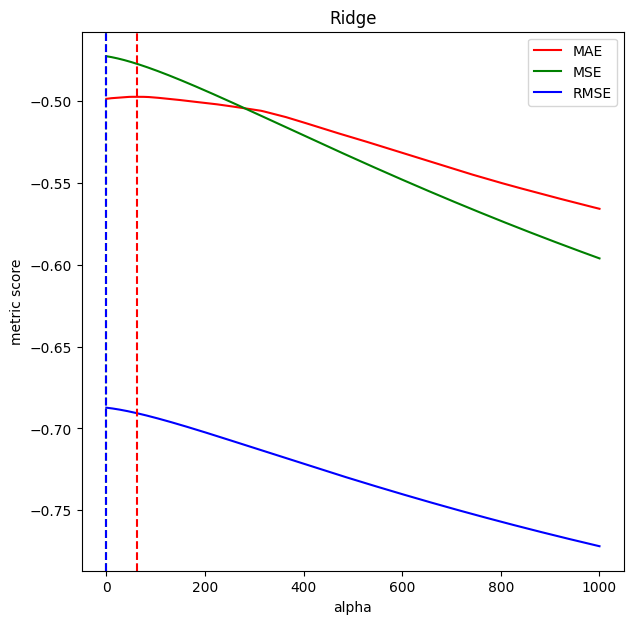

Best alpha by MAE:  61.62464985994397
Best alpha by MSE:  0.0
Best alpha by RMSE:  0.0


In [194]:
best_ridge_alpha_by_mae, best_ridge_alpha_by_mse, best_ridge_alpha_by_rmse = find_best_reg_alpha(
    np.linspace(0, 1000, 2500),
    X_train, y_train, X_test, y_test,
    regressor_name="Ridge",
)

print("Best alpha by MAE: ", best_ridge_alpha_by_mae)
print("Best alpha by MSE: ", best_ridge_alpha_by_mse)
print("Best alpha by RMSE: ", best_ridge_alpha_by_rmse)

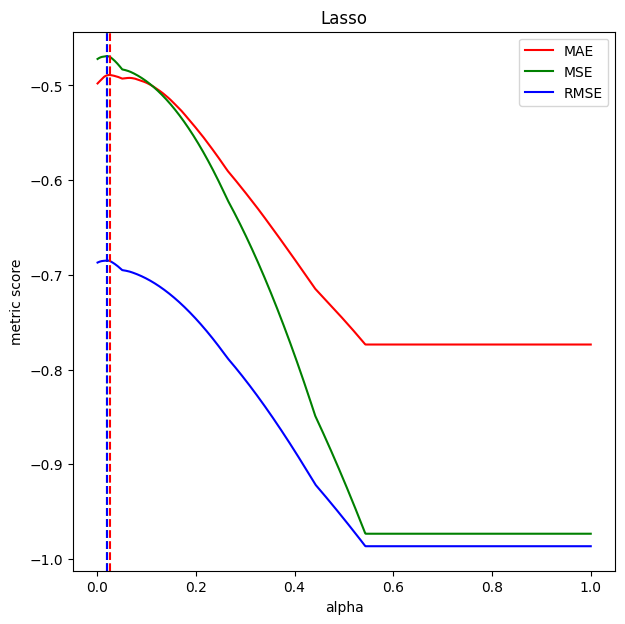

Best alpha by MAE:  0.026000000000000002
Best alpha by MSE:  0.02
Best alpha by RMSE:  0.02


In [197]:
best_lasso_alpha_by_mae, best_lasso_alpha_by_mse, best_lasso_alpha_by_rmse = find_best_reg_alpha(
    np.linspace(0.001, 1, 1000),
    X_train, y_train, X_test, y_test,
    regressor_name="Lasso",
)
print("Best alpha by MAE: ", best_lasso_alpha_by_mae)
print("Best alpha by MSE: ", best_lasso_alpha_by_mse)
print("Best alpha by RMSE: ", best_lasso_alpha_by_rmse)

#### Улучшение токенизации

*(Везде далее будет использоваться Lasso-регреccия с параметром alpha=0.02, а строки с null-значениями будут удаляться)*

In [354]:
def make_doc2vec_tagged_dataset(original_data, tokenize_text):
    new_data = original_data.dropna(inplace=False)
    new_data = new_data.reset_index(drop=True)
    new_data["text"] = new_data.Description.apply(tokenize_text)

    input_text = list(new_data.text.values)
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]

    #print("Example of tagged document: ")
    #print(documents[10:12])

    model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
    
    vectors = list(map(lambda x : list(model.dv[x.tags][0]), documents))

    split_df = pd.DataFrame(vectors, columns=['v1', 'v2', 'v3','v4',"v5"])
    result = new_data.join(split_df, how='left')

    new_data_sm = result[[
        'Runtime (Minutes)',
        "Year",
        'Rating',
        'Votes',
        'Revenue (Millions)',
        'Metascore',
        "v1", "v2", "v3", "v4", "v5"
    ]]

    return new_data_sm

In [372]:
def print_statistics_of_tokenization(original_data, tokenize_text):
    better_data_sm = make_doc2vec_tagged_dataset(original_data, tokenize_text)

    X = better_data_sm.drop(["Rating"],axis=1).values
    y = better_data_sm['Rating'].values

    sc = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(X), y, random_state=42)

    regressor = Lasso(alpha=0.02)
    regressor.fit(X_train, y_train)
    y_preds = regressor.predict(X_test)

    print("MAE: ", mean_absolute_error(y_test, y_preds))
    print("MSE: ", mean_squared_error(y_test, y_preds, squared=True))
    print("RMSE: ", mean_squared_error(y_test, y_preds, squared=False))

#### Простая токенизация через split

In [373]:
print_statistics_of_tokenization(pd.read_csv('IMDB-Movie-Data.csv'), lambda x: x.lower().split())

MAE:  0.3981254917939126
MSE:  0.3674332350226849
RMSE:  0.6061627133226564


##### Токенизация из Gensim

In [374]:
from gensim.utils import tokenize

print_statistics_of_tokenization(pd.read_csv('IMDB-Movie-Data.csv'), lambda x: list(tokenize(x.lower())))

MAE:  0.3984544795982772
MSE:  0.36768544942107245
RMSE:  0.6063707194621722


#### Токенизация из nltk

In [375]:
from nltk.tokenize import word_tokenize

print_statistics_of_tokenization(pd.read_csv('IMDB-Movie-Data.csv'), lambda x: list(word_tokenize(x.lower())))

MAE:  0.3983181467301091
MSE:  0.36743942794732837
RMSE:  0.6061678216033315


Итог: разные виды токенизации не влияют на качество предсказаний модели для этого набора данных.